In [1]:
import numpy as np
import pandas as pd
from umap import UMAP
 
import matplotlib
import matplotlib.pyplot as plt
 
import requests
import time
import json
import pandas as pd
from bertopic import BERTopic

%matplotlib inline

In [2]:
#Subset of products for faster bertopic
sales_analysis = pd.read_csv('intermediary_datasets/sales_analysis.csv')
sales_analysis = sales_analysis.iloc[0:100000]

In [3]:
products = sales_analysis[['Description']]

In [4]:
products

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
99995,PORCELAIN BUDAH INCENSE HOLDER
99996,PINK HORSE SOCK PUPPET KIT
99997,POPPY'S PLAYHOUSE BEDROOM
99998,MAGIC SHEEP WOOL GROWING FROM PAPER


In [ ]:
products = products.squeeze().astype(str)

In [ ]:
model = BERTopic()
topics, probs = model.fit_transform(products)

In [ ]:
model.get_topic_freq()

,Topic,Count
0,-1,897
1,0,580
2,1,505
3,2,395
4,3,392
...,...,...
1939,1955,11
1938,1947,11
1957,1956,10
1958,1957,10


In [ ]:
model.get_topic_info()

,Topic,Count,Name
0,-1,897,-1_chilli_sally_cakestand_scotty
1,0,580,0_tlight_holder_hanging_white
2,1,505,1_jumbo_retrospot_red_bag
3,2,395,2_lunch_retrospot_red_bag
4,3,392,3_cakestand_tier_regency_
...,...,...,...
1955,1954,11,1954_fishing_gnome_gold_silver
1956,1955,11,1955_inflatable_globe_political_groovy
1957,1956,10,1956_rubbers_circular_swirly_kids
1958,1957,10,1957_drawers_hut_hall_beach


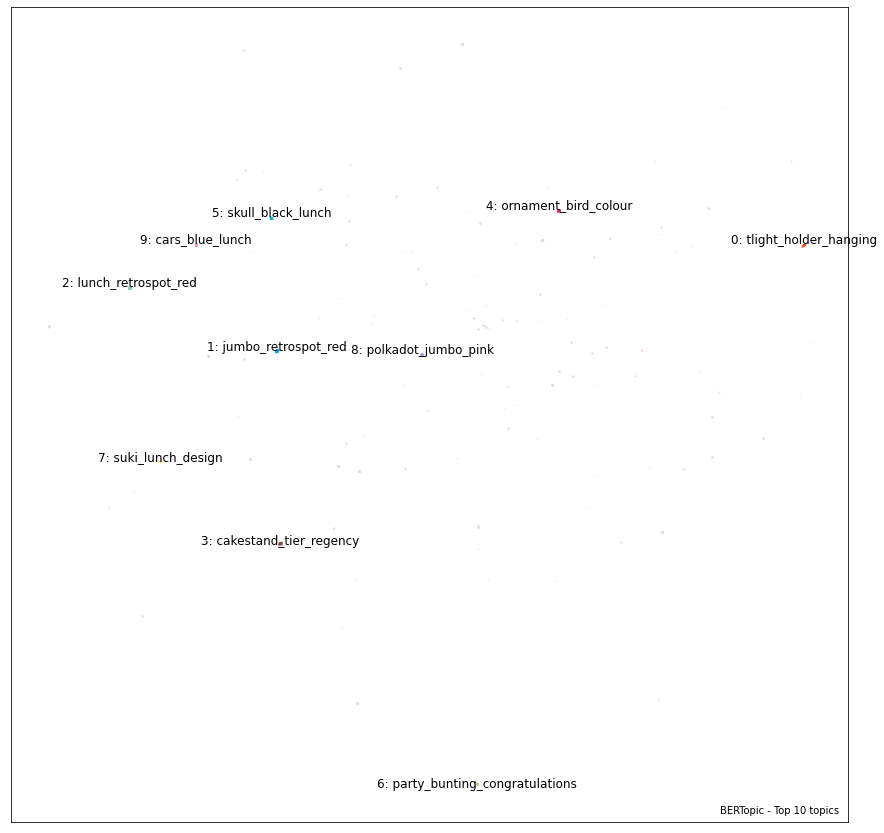

In [ ]:
# Prepare data for plotting
embeddings = model._extract_embeddings(products, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics
 
# Plot parameters
top_n = 10
fontsize = 12
 
# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
 
# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])
 
# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)
 
# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:3]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')
 
ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.savefig("BERTopic_topic_clusters.png")
plt.show()

In [ ]:
topic_labels= [model.get_topic(freq)[0][0] for freq in topics]
sales_analysis['category'] = topic_labels

In [45]:
sales_analysis.drop(['InvoiceNo', 'StockCode', 'Product Description'], inplace=True, axis=1)

In [46]:
sales_analysis.to_csv('intermediary_datasets/extracted_topics.csv', index = False)